In [5]:
from keras.datasets import mnist    
from scipy.io import loadmat
from models.utils import ResNet18, split_dataframe, detect_drifts
from skimage.transform import resize
import keras
import numpy as np
import models.unmasking_drift_detector as unm
import models.d3_drift_detector as d3
import matplotlib.pyplot as plt

In [2]:
(mnist_images, _), (_, _) = mnist.load_data()
mnist_images = resize(mnist_images, (mnist_images.shape[0],32,32,3))

svhn_data = loadmat('train_32x32.mat')
svhn_images, svhn_labels = svhn_data['X'], svhn_data['y']
svhn_images = np.moveaxis(svhn_images, -1, 0)
cap = svhn_images.shape[0] // 2
idx = int(0.8 * cap)

In [8]:
svhn_labels -= 1
X_train, X_test = svhn_images[:idx], svhn_images[idx:cap]
y_train, y_test = svhn_labels[:idx], svhn_labels[idx:cap]

In [10]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [14]:
model = ResNet18(input_shape=(32, 32, 3), n_classes=10)

In [15]:
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
458/458 [==============================] - 390s 843ms/step - loss: 1.0530 - accuracy: 0.6609 - val_loss: 0.8744 - val_accuracy: 0.7341
Epoch 2/3
458/458 [==============================] - 380s 831ms/step - loss: 0.4994 - accuracy: 0.8451 - val_loss: 1.3445 - val_accuracy: 0.6866
Epoch 3/3
458/458 [==============================] - 374s 818ms/step - loss: 0.4001 - accuracy: 0.8756 - val_loss: 0.5081 - val_accuracy: 0.8440


In [16]:
extract_features_model = keras.Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

In [17]:
svhn_images
mnist_images
drifted_data = np.empty((0, 32, 32, 3))
i = 0
last_index = 0
current_index = 0
ground_truth_drifts = []

dimension_limit = 0.6 * (svhn_images.shape[0] + 0.5*mnist_images.shape[0])
while drifted_data.shape[0] < dimension_limit:
    current_index += np.random.choice([400, 800, 1200, 1600])
    if i % 2 == 0:
        if i != 0:
            ground_truth_drifts.append(drifted_data.shape[0])
        svhn_batch = svhn_images[3*last_index:3*current_index]
        drifted_data = np.concatenate((drifted_data, svhn_batch), axis=0)
    else:
        # ground_truth_drifts.append(drifted_data.shape[0])
        svhn_batch = svhn_images[2*last_index:2*current_index]
        batch = np.concatenate((svhn_batch, mnist_images[last_index:current_index]), axis=0)
        np.random.shuffle(batch)
        drifted_data = np.concatenate((drifted_data, batch), axis=0)
    i += 1
    last_index = current_index

In [18]:
ground_truth_drifts, drifted_data.shape

([7200, 12000, 18000, 20400, 27600, 36000, 44400, 50400, 57600],
 (62400, 32, 32, 3))

In [19]:
features = extract_features_model.predict(drifted_data)
features.shape

1950/1950 [==============================] - 29s 15ms/step


(62400, 512)

In [25]:
batch_size = 400
data_splitted = split_dataframe(features, batch_size)
ground_truth_drifts_batch = np.array(ground_truth_drifts) / 400
ground_truth_drifts_batch = ground_truth_drifts_batch.astype(int)
ground_truth_drifts_batch

array([ 18,  30,  45,  51,  69,  90, 111, 126, 144])

In [27]:
np.save("ground_truth_drifts_batch.npy", ground_truth_drifts_batch)
np.save("features.npy", features)

D3:
1.0
Unmasking:
Threshold = 0.5
0.10465116279069768
Threshold = 0.53
0.2727272727272727
Threshold = 0.54
0.375
Threshold = 0.55
0.75
Threshold = 0.56
0.9
Threshold = 0.57
0.7272727272727273
Threshold = 0.6
0.3333333333333333


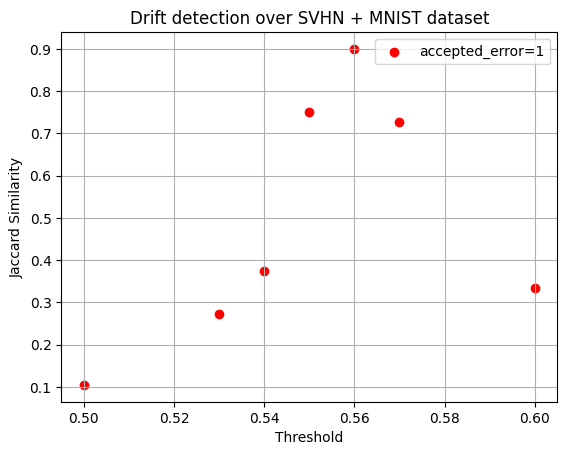

In [34]:

thresholds = [0.5, 0.53, 0.54, 0.55, 0.56, 0.57, 0.6]
jaccard_sim_unm = []

print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=False)
print(sim_d3)

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=1, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)




plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN + MNIST dataset')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
# plt.plot(percentages, [sim_d3]*len(percentages), c='blue', label='d3')
plt.grid()
plt.legend()
plt.savefig('/images/svhn_jaccard_thresholds_error1.png')
plt.show()


D3:
1.0
Unmasking:
Threshold = 0.5
0.08256880733944955
Threshold = 0.53
0.2571428571428571
Threshold = 0.54
0.45
Threshold = 0.55
0.42105263157894735
Threshold = 0.56
0.6666666666666666
Threshold = 0.57
0.38461538461538464
Threshold = 0.6
0.2222222222222222


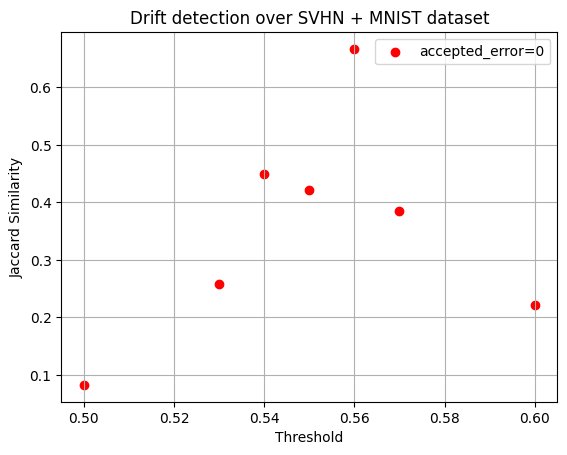

In [35]:

thresholds = [0.5, 0.53, 0.54, 0.55, 0.56, 0.57, 0.6]
jaccard_sim_unm = []

print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=0, show_drifts=False)
print(sim_d3)

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=0, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)




plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN + MNIST dataset')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=0')
plt.grid()
# plt.plot(percentages, [sim_d3]*len(percentages), c='blue', label='d3')
plt.legend()
plt.savefig('/images/svhn_jaccard_thresholds_error0.png')
plt.show()

Unmasking:
Percent = 0.05
0.6153846153846154
Percent = 0.15
0.75
Percent = 0.25
0.8181818181818182
Percent = 0.35
0.6923076923076923
Percent = 0.45
0.8888888888888888
Percent = 0.55
0.75
Percent = 0.65
0.5333333333333333


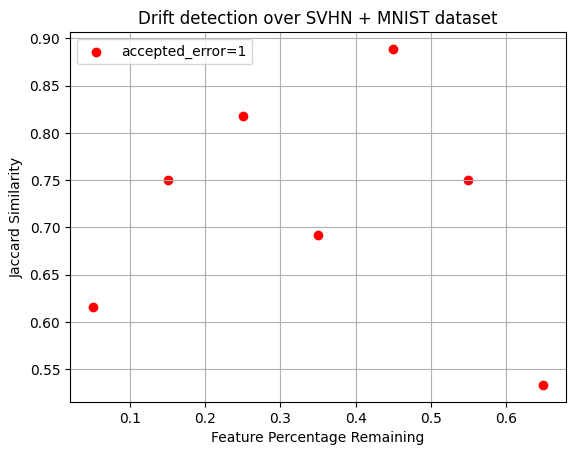

In [36]:
percents = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65]
jaccard_sim_unm = []

# print("D3:")
# sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=False)
# print(sim_d3)

print("Unmasking:")
for p in percents:
    print(f"Percent = {p}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=1, min_feature_percentage_remaining=p)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)




plt.xlabel('Feature Percentage Remaining')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN + MNIST dataset')

plt.scatter(percents, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
# plt.plot(percentages, [sim_d3]*len(percentages), c='blue', label='d3')
plt.grid()
plt.legend()
plt.savefig('/images/svhn_jaccard_percents_error1.png')
plt.show()
